In [31]:
import pandas as pd
import numpy as np
from scipy import stats
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

np.set_printoptions(linewidth=np.inf, suppress=True, precision=2)

In [32]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score 

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import tensorflow as tf

from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,ExpSineSquared, DotProduct,ConstantKernel)
from sklearn.gaussian_process import GaussianProcessRegressor  
from sklearn.svm import SVR

import mitosheet

In [33]:
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

pyo.init_notebook_mode(connected=True)

In [34]:
results = []

### Unstructured Variance, n_input = 12, n_output = 1

In [35]:
df = pd.read_excel("Data/US15I1O.xlsx", index_col = 0)
df

,Input 01,Input 02,Input 03,Input 04,Input 05,Input 06,Input 07,Input 08,Input 09,Input 10,Input 11,Input 12,Input 13,Input 14,Input 15,Output 01
DMU 0001,275.46,50.34,340.07,198.33,252.31,152.33,171.94,351.93,99.92,276.03,521.97,377.73,182.73,323.82,149.79,604.61
DMU 0002,215.47,60.38,340.06,310.86,293.92,194.99,213.47,449.00,236.11,219.68,448.57,389.20,136.40,381.47,155.19,549.84
DMU 0003,300.23,64.11,340.12,309.33,318.17,150.53,158.62,260.07,220.55,198.77,347.80,180.49,143.57,314.84,152.35,374.89
DMU 0004,318.80,70.69,340.03,308.70,284.31,177.03,184.56,248.79,196.65,194.76,308.82,370.43,154.72,236.00,150.82,308.83
DMU 0005,308.48,76.50,340.03,300.18,320.88,186.92,207.32,311.17,217.06,213.73,369.79,371.99,140.98,334.56,153.16,478.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DMU 0996,229.84,62.77,340.10,307.80,251.16,170.90,181.09,345.93,209.08,206.03,420.21,324.91,145.44,267.75,152.00,434.69
DMU 0997,277.75,63.85,340.07,297.61,292.52,163.04,211.13,295.84,217.56,231.60,454.72,233.57,140.77,400.10,155.33,528.69
DMU 0998,245.12,44.22,340.05,310.36,284.72,157.20,154.61,341.60,168.51,281.86,383.23,351.73,166.37,259.97,151.17,448.42
DMU 0999,229.51,72.14,340.09,313.09,277.03,161.84,177.60,347.74,232.43,226.38,397.84,333.21,132.83,351.30,154.23,483.78


In [36]:
df_sol = pd.read_excel("US15I1O_Solution.xlsx", index_col = 0)[["Efficiency_Scores"]]
df_sol

,Efficiency_Scores
DMU 0001,1.000000
DMU 0002,0.812848
DMU 0003,0.807381
DMU 0004,0.601498
DMU 0005,0.783913
...,...
DMU 0996,0.729545
DMU 0997,0.944673
DMU 0998,0.783763
DMU 0999,0.758824


In [37]:
import mitosheet
mitosheet.sheet(df_sol, view_df=True)

MitoWidget(analysis_data_json='{"analysisName": "UUID-74683031-14a0-4bab-882a-acc316160d94", "code": {"imports…

In [38]:
df_weights = pd.read_excel("US15I1O_Solution.xlsx", index_col = 0).iloc[:, 1:]
df_weights

,Weight_Input 01,Weight_Input 02,Weight_Input 03,Weight_Input 04,Weight_Input 05,Weight_Input 06,Weight_Input 07,Weight_Input 08,Weight_Input 09,Weight_Input 10,Weight_Input 11,Weight_Input 12,Weight_Input 13,Weight_Input 14,Weight_Input 15,Weight_Output 01
DMU 0001,0.000000,0.012013,0.0,0.000548,0.000000,0.000000,0.000000,0.000000,0.002868,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.001654
DMU 0002,0.000000,0.004071,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002082,0.000000,0.000000,0.002176,0.000000,0.0,0.001478
DMU 0003,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000149,0.000000,0.000000,0.000451,0.002424,0.000000,0.001165,0.0,0.002154
DMU 0004,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.001481,0.000000,0.000000,0.002045,0.000000,0.000000,0.000000,0.0,0.001948
DMU 0005,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000881,0.000000,0.000685,0.001092,0.000473,0.000000,0.000000,0.0,0.001637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DMU 0996,0.000262,0.000000,0.0,0.000000,0.000521,0.000000,0.000000,0.000022,0.000000,0.000081,0.000000,0.001482,0.000000,0.001132,0.0,0.001678
DMU 0997,0.000000,0.000000,0.0,0.000000,0.000000,0.001676,0.000000,0.001441,0.000000,0.000062,0.000000,0.001225,0.000000,0.000000,0.0,0.001787
DMU 0998,0.000000,0.007942,0.0,0.000000,0.000000,0.000000,0.001201,0.000000,0.000000,0.000000,0.000126,0.000492,0.000000,0.000930,0.0,0.001748
DMU 0999,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000475,0.000000,0.000450,0.001066,0.000676,0.000628,0.000000,0.0,0.001569


In [39]:
df_zero =(df_weights==0).sum()
df_zero

Weight_Input 01     777
Weight_Input 02     776
Weight_Input 03     998
Weight_Input 04     888
Weight_Input 05     846
Weight_Input 06     836
Weight_Input 07     896
Weight_Input 08     443
Weight_Input 09     832
Weight_Input 10     596
Weight_Input 11     424
Weight_Input 12     321
Weight_Input 13     880
Weight_Input 14     386
Weight_Input 15     990
Weight_Output 01      0
dtype: int64

### ML

In [40]:
X = df
X.head()

,Input 01,Input 02,Input 03,Input 04,Input 05,Input 06,Input 07,Input 08,Input 09,Input 10,Input 11,Input 12,Input 13,Input 14,Input 15,Output 01
DMU 0001,275.46,50.34,340.07,198.33,252.31,152.33,171.94,351.93,99.92,276.03,521.97,377.73,182.73,323.82,149.79,604.61
DMU 0002,215.47,60.38,340.06,310.86,293.92,194.99,213.47,449.00,236.11,219.68,448.57,389.20,136.40,381.47,155.19,549.84
DMU 0003,300.23,64.11,340.12,309.33,318.17,150.53,158.62,260.07,220.55,198.77,347.80,180.49,143.57,314.84,152.35,374.89
DMU 0004,318.80,70.69,340.03,308.70,284.31,177.03,184.56,248.79,196.65,194.76,308.82,370.43,154.72,236.00,150.82,308.83
DMU 0005,308.48,76.50,340.03,300.18,320.88,186.92,207.32,311.17,217.06,213.73,369.79,371.99,140.98,334.56,153.16,478.87


In [41]:
y = df_sol
y.head()

,Efficiency_Scores
DMU 0001,1.000000
DMU 0002,0.812848
DMU 0003,0.807381
DMU 0004,0.601498
DMU 0005,0.783913


In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
std_scaler = StandardScaler()
mm_scaler = MinMaxScaler()

In [44]:
dt_model = DecisionTreeRegressor(random_state=42)

pipe_dt = make_pipeline(std_scaler, dt_model)

# cross-validate the pipeline
print("neg_mean_squared_error:", cross_val_score(pipe_dt, X, y, scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_dt, X, y, scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_dt, X, y, scoring="r2").mean())

neg_mean_squared_error: -0.0038383300720867624
neg_root_mean_squared_error: -0.06189538346515995
r2: 0.7292108095068011


In [45]:
# specify parameter values to search
params = {}
params['decisiontreeregressor__max_depth'] = list(range(1, 15))
params['decisiontreeregressor__min_samples_split'] = list(range(10, 60, 10))
params['decisiontreeregressor__max_features'] = ["auto","log2","sqrt",None]

In [46]:
grid = GridSearchCV(pipe_dt, params, cv=5, scoring="neg_root_mean_squared_error")
grid.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('decisiontreeregressor',
                                        DecisionTreeRegressor(random_state=42))]),
             param_grid={'decisiontreeregressor__max_depth': [1, 2, 3, 4, 5, 6,
                                                              7, 8, 9, 10, 11,
                                                              12, 13, 14],
                         'decisiontreeregressor__max_features': ['auto', 'log2',
                                                                 'sqrt', None],
                         'decisiontreeregressor__min_samples_split': [10, 20,
                                                                      30, 40,
                                                                      50]},
             scoring='neg_root_mean_squared_error')

In [47]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)
print("r2:", cross_val_score(grid.best_estimator_, X, y, scoring="r2").mean())

-0.055881016447620516
{'decisiontreeregressor__max_depth': 14, 'decisiontreeregressor__max_features': 'auto', 'decisiontreeregressor__min_samples_split': 20}
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=14, max_features='auto',
                                       min_samples_split=20,
                                       random_state=42))])
r2: 0.7753617717548623


In [48]:
imp_dt = grid.best_estimator_.steps[1][1].feature_importances_
imp_dt

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.01, 0.01, 0.03, 0.04, 0.  , 0.08, 0.  , 0.77])

In [49]:
#pipe_dt.fit(X, y)
#
#imp_dt = pipe_dt.steps[1][1].feature_importances_
#imp_dt

In [50]:
df_dt = pd.DataFrame({"Feature Name":X.columns, "Importance": imp_dt}).sort_values("Importance", ascending=False)
df_dt

,Feature Name,Importance
15,Output 01,0.769294
13,Input 14,0.084379
11,Input 12,0.044802
10,Input 11,0.034240
7,Input 08,0.032133
...,...,...
14,Input 15,0.002014
3,Input 04,0.001900
0,Input 01,0.001672
5,Input 06,0.001568


In [51]:
input_imp = list(df_dt.loc[df_dt["Feature Name"].str.contains("Input"), "Feature Name"].values)
results.append((grid.best_estimator_.steps[1][0], input_imp,
                {"r2" : cross_val_score(grid.best_estimator_, X, y, scoring="r2").mean(),
                "neg_root_mean_squared_error": grid.best_score_}))

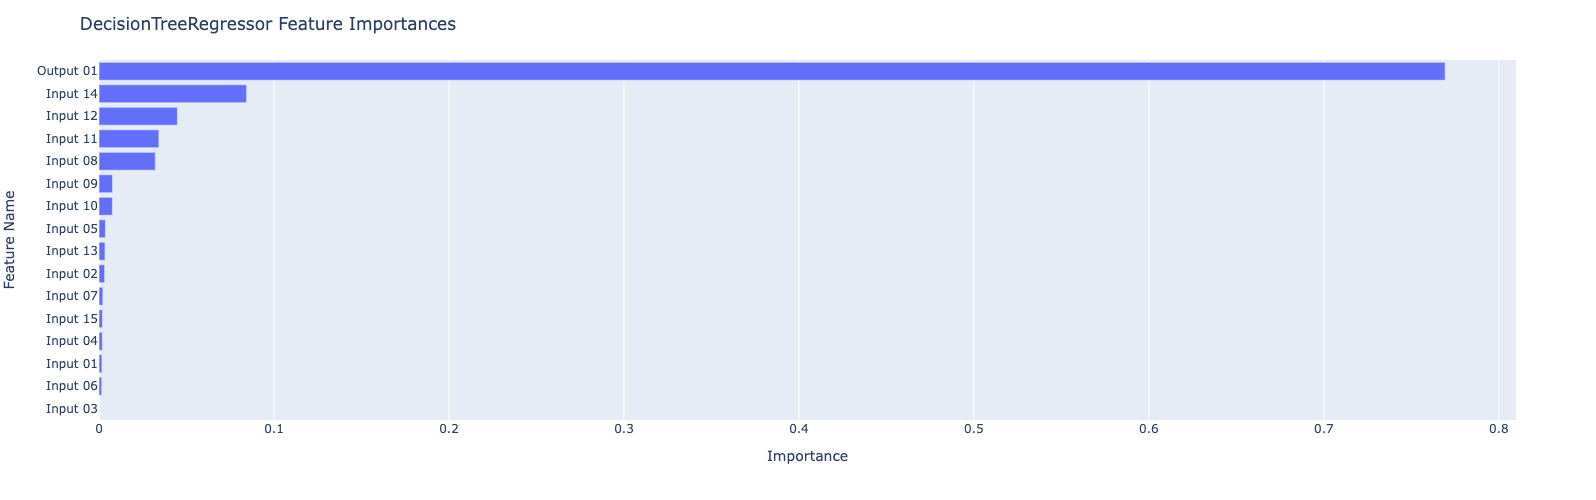

In [52]:
fig = px.bar(df_dt, x="Importance", y="Feature Name")

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"DecisionTreeRegressor Feature Importances",
    yaxis={'categoryorder':'total ascending'}
)

fig.show()

In [53]:
df_zero.index = [f.split("_")[1] for f in df_zero.index]

In [54]:
df_merged = pd.merge(df_dt, df_zero.reset_index(), left_on="Feature Name", right_on="index")
df_merged.rename(columns = {0: "Zero_Count"}, inplace=True)
df_merged

,Feature Name,Importance,index,Zero_Count
0,Output 01,0.769294,Output 01,0
1,Input 14,0.084379,Input 14,386
2,Input 12,0.044802,Input 12,321
3,Input 11,0.034240,Input 11,424
4,Input 08,0.032133,Input 08,443
...,...,...,...,...
11,Input 15,0.002014,Input 15,990
12,Input 04,0.001900,Input 04,888
13,Input 01,0.001672,Input 01,777
14,Input 06,0.001568,Input 06,836


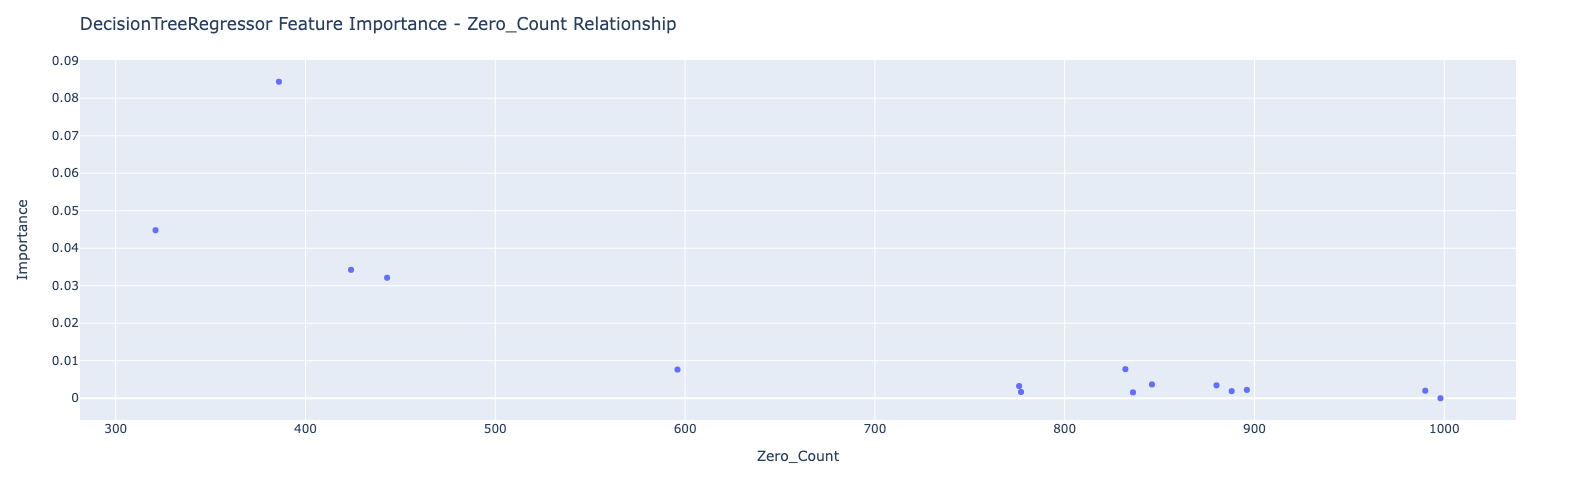

In [55]:
fig = px.scatter(df_merged[~df_merged["Feature Name"].str.contains("Output")], x="Zero_Count", y="Importance",
                hover_data=["Feature Name"])

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"DecisionTreeRegressor Feature Importance - Zero_Count Relationship",
)

fig.show()

In [56]:
rf_model = RandomForestRegressor(random_state=42)

pipe_rf = make_pipeline(std_scaler, rf_model)


# cross-validate the pipeline
print("neg_mean_squared_error:", cross_val_score(pipe_rf, X, y.values.ravel(), scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_rf, X, y.values.ravel(), scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_rf, X, y.values.ravel(), scoring="r2").mean())

neg_mean_squared_error: -0.001775778893901924
neg_root_mean_squared_error: -0.04197198832619174
r2: 0.8739532791575707


In [57]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
print(n_estimators)
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
print(max_depth)
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid

[200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


In [58]:
# specify parameter values to search
params = {}
params['randomforestregressor__n_estimators'] = n_estimators
params['randomforestregressor__max_features'] = max_features
params['randomforestregressor__max_depth'] = max_depth
params['randomforestregressor__min_samples_split'] = min_samples_split
params['randomforestregressor__min_samples_leaf'] = min_samples_leaf
params['randomforestregressor__bootstrap'] = bootstrap

In [59]:
grid = RandomizedSearchCV(pipe_rf, params, cv=5, scoring="neg_root_mean_squared_error")
grid.fit(X, y.values.ravel())

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('randomforestregressor',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'randomforestregressor__bootstrap': [True,
                                                                             False],
                                        'randomforestregressor__max_depth': [10,
                                                                             20,
                                                                             30,
                                                                             40,
                                                                             50,
                                                                             60,
                                

In [60]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)
print("r2:", cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean())

-0.042086080554349405
{'randomforestregressor__n_estimators': 400, 'randomforestregressor__min_samples_split': 5, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__max_features': 'auto', 'randomforestregressor__max_depth': None, 'randomforestregressor__bootstrap': True}
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(min_samples_leaf=2, min_samples_split=5,
                                       n_estimators=400, random_state=42))])
r2: 0.8732917190720414


In [61]:
imp_rf = grid.best_estimator_.steps[1][1].feature_importances_
imp_rf

array([0.  , 0.01, 0.01, 0.01, 0.01, 0.  , 0.  , 0.03, 0.01, 0.01, 0.05, 0.03, 0.  , 0.08, 0.  , 0.74])

In [62]:
#pipe_rf.fit(X, y.values.ravel())
#
#imp_rf = pipe_rf.steps[1][1].feature_importances_

In [63]:
df_rf = pd.DataFrame({"Feature Name":X.columns, "Importance": imp_rf}).sort_values("Importance", ascending=False)
df_rf

,Feature Name,Importance
15,Output 01,0.739297
13,Input 14,0.079591
10,Input 11,0.046813
11,Input 12,0.034703
7,Input 08,0.031852
...,...,...
6,Input 07,0.004982
5,Input 06,0.004946
0,Input 01,0.004849
14,Input 15,0.004656


In [64]:
input_imp = list(df_rf.loc[df_rf["Feature Name"].str.contains("Input"), "Feature Name"].values)
results.append((grid.best_estimator_.steps[1][0], input_imp,
                {"r2" : cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean(),
                "neg_root_mean_squared_error": grid.best_score_}))

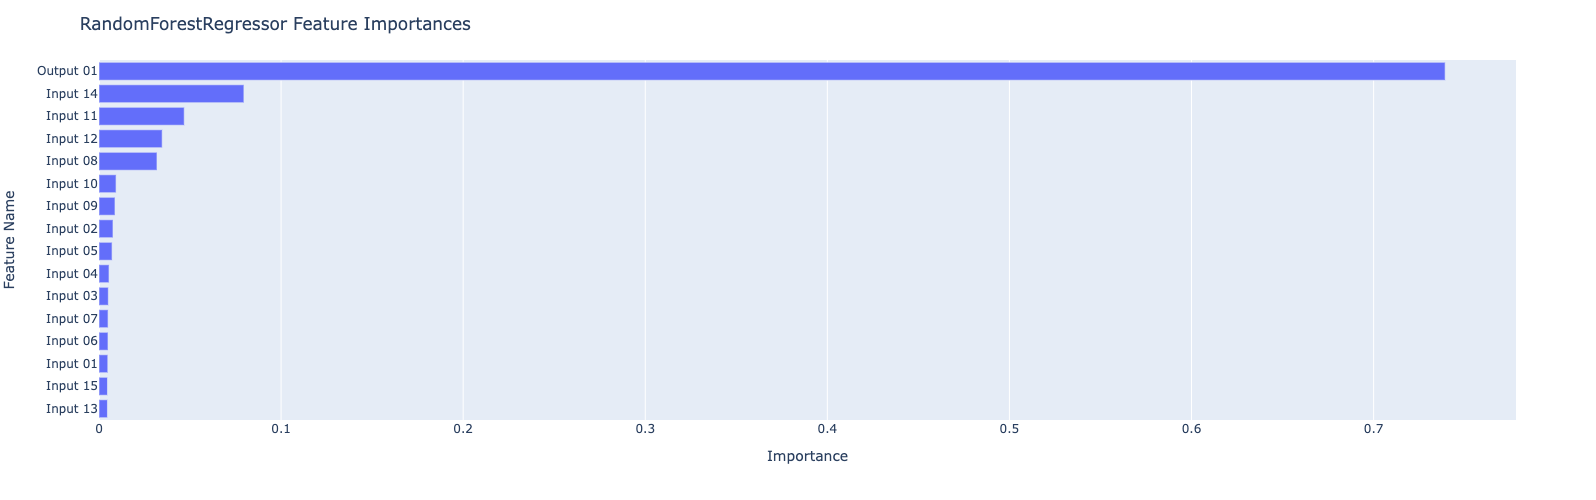

In [65]:
fig = px.bar(df_rf, x="Importance", y="Feature Name")

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"RandomForestRegressor Feature Importances",
    yaxis={'categoryorder':'total ascending'}
)

fig.show()

In [66]:
df_merged = pd.merge(df_rf, df_zero.reset_index(), left_on="Feature Name", right_on="index")
df_merged.rename(columns = {0: "Zero_Count"}, inplace=True)
df_merged

,Feature Name,Importance,index,Zero_Count
0,Output 01,0.739297,Output 01,0
1,Input 14,0.079591,Input 14,386
2,Input 11,0.046813,Input 11,424
3,Input 12,0.034703,Input 12,321
4,Input 08,0.031852,Input 08,443
...,...,...,...,...
11,Input 07,0.004982,Input 07,896
12,Input 06,0.004946,Input 06,836
13,Input 01,0.004849,Input 01,777
14,Input 15,0.004656,Input 15,990


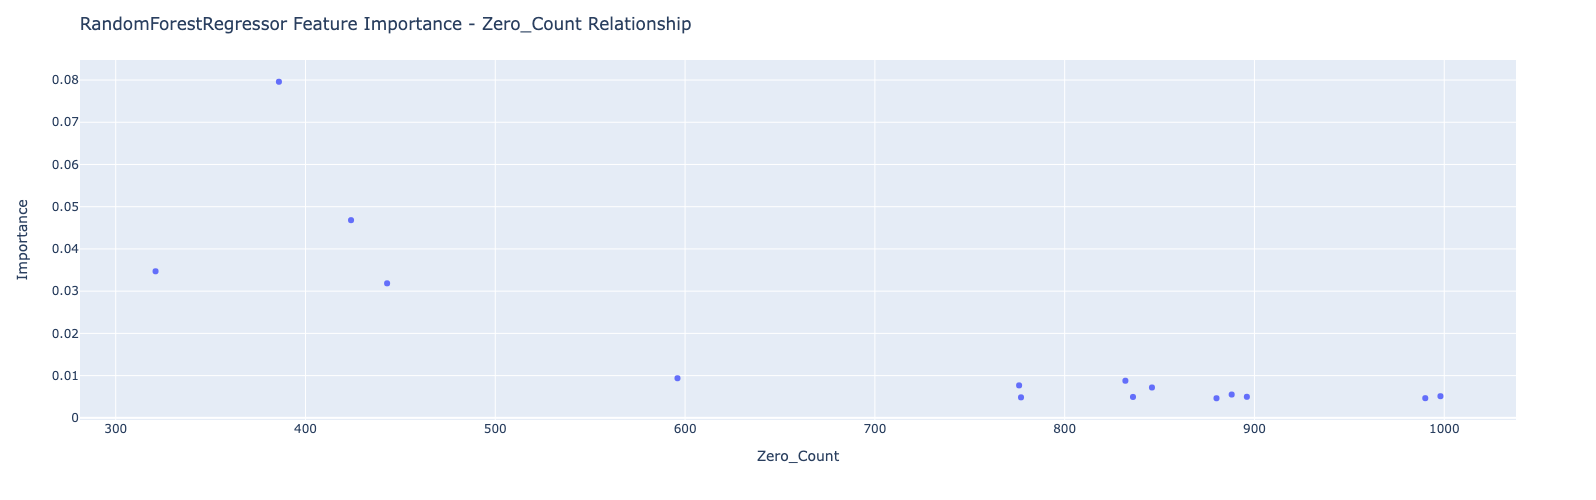

In [67]:
fig = px.scatter(df_merged[~df_merged["Feature Name"].str.contains("Output")], x="Zero_Count", y="Importance",
                hover_data=["Feature Name"])

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"RandomForestRegressor Feature Importance - Zero_Count Relationship",
)

fig.show()

In [68]:
gb_model = GradientBoostingRegressor(random_state=42)

pipe_gb = make_pipeline(std_scaler, gb_model)

# cross-validate the pipeline
print("neg_mean_squared_error:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="r2").mean())

neg_mean_squared_error: -0.0012632006584113041
neg_root_mean_squared_error: -0.0353870503742757
r2: 0.9100600772382721


In [69]:
#learning_rate = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
#n_estimators = [200, 500, 1000, 2000]
#max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
#print(max_depth)
#max_depth.append(None)
## Minimum number of samples required to split a node
#min_samples_split = [2, 5, 10]
## Minimum number of samples required at each leaf node
#min_samples_leaf = [1, 2, 4]

In [70]:
learning_rate = [1, 0.5, 0.1,  0.01]
n_estimators = [50, 100, 200, 500, 1000, 2000]
max_depth = [3, 5, 10, None]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 20, 30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
subsample = [0.3, 0.5, 0.75, 1.0]

In [71]:
# specify parameter values to search
params = {}
params['gradientboostingregressor__learning_rate'] = learning_rate
params['gradientboostingregressor__n_estimators'] = n_estimators
params['gradientboostingregressor__max_depth'] = max_depth
params['gradientboostingregressor__min_samples_split'] = min_samples_split
params['gradientboostingregressor__min_samples_leaf'] = min_samples_leaf
params['gradientboostingregressor__subsample'] = subsample

In [72]:
grid = RandomizedSearchCV(pipe_gb, params, cv=5, scoring="neg_root_mean_squared_error", random_state=0)
grid.fit(X, y.values.ravel())

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('gradientboostingregressor',
                                              GradientBoostingRegressor(random_state=42))]),
                   param_distributions={'gradientboostingregressor__learning_rate': [1,
                                                                                     0.5,
                                                                                     0.1,
                                                                                     0.01],
                                        'gradientboostingregressor__max_depth': [3,
                                                                                 5,
                                                                                 10,
                                                                 

In [73]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)
print("r2:", cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean())

-0.026640962034065747
{'gradientboostingregressor__subsample': 0.3, 'gradientboostingregressor__n_estimators': 500, 'gradientboostingregressor__min_samples_split': 30, 'gradientboostingregressor__min_samples_leaf': 2, 'gradientboostingregressor__max_depth': 5, 'gradientboostingregressor__learning_rate': 0.1}
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(max_depth=5, min_samples_leaf=2,
                                           min_samples_split=30,
                                           n_estimators=500, random_state=42,
                                           subsample=0.3))])
r2: 0.9487702156140901


In [74]:
imp_gb = grid.best_estimator_.steps[1][1].feature_importances_
imp_gb

array([0.01, 0.01, 0.  , 0.01, 0.01, 0.01, 0.01, 0.04, 0.02, 0.03, 0.05, 0.06, 0.01, 0.1 , 0.01, 0.62])

In [75]:
#pip_gb.fit(X, y.values.ravel())
#
#imp_gb = pip_gb.steps[1][1].feature_importances_

In [76]:
df_gb = pd.DataFrame({"Feature Name":X.columns, "Importance": imp_gb}).sort_values("Importance", ascending=False)
df_gb

,Feature Name,Importance
15,Output 01,0.620830
13,Input 14,0.102176
11,Input 12,0.060905
10,Input 11,0.054743
7,Input 08,0.041807
...,...,...
14,Input 15,0.007803
12,Input 13,0.006719
5,Input 06,0.006497
6,Input 07,0.006016


In [77]:
input_imp = list(df_gb.loc[df_gb["Feature Name"].str.contains("Input"), "Feature Name"].values)
results.append((grid.best_estimator_.steps[1][0], input_imp,
                {"r2" : cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean(),
                "neg_root_mean_squared_error": grid.best_score_}))

In [78]:
fig = px.bar(df_gb, x="Importance", y="Feature Name")

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"GradientBoostingRegressor Feature Importances",
    yaxis={'categoryorder':'total ascending'}
)

fig.show()

In [79]:
df_merged = pd.merge(df_gb, df_zero.reset_index(), left_on="Feature Name", right_on="index")
df_merged.rename(columns = {0: "Zero_Count"}, inplace=True)
df_merged

,Feature Name,Importance,index,Zero_Count
0,Output 01,0.620830,Output 01,0
1,Input 14,0.102176,Input 14,386
2,Input 12,0.060905,Input 12,321
3,Input 11,0.054743,Input 11,424
4,Input 08,0.041807,Input 08,443
...,...,...,...,...
11,Input 15,0.007803,Input 15,990
12,Input 13,0.006719,Input 13,880
13,Input 06,0.006497,Input 06,836
14,Input 07,0.006016,Input 07,896


In [80]:
fig = px.scatter(df_merged[~df_merged["Feature Name"].str.contains("Output")], x="Zero_Count", y="Importance",
                hover_data=["Feature Name"])

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"GradientBoostingRegressor Feature Importance - Zero_Count Relationship",
)

fig.show()

In [81]:
model = grid.best_estimator_.fit(X_train, y_train.values.ravel())
prediction = model.predict(X_test)

In [82]:
res = pd.DataFrame()
res["Prediction"] = pd.Series(prediction.ravel())
res["Actual"] = y_test.values
res["Diff"] = res.Prediction - res.Actual
res["Error_Perc"] = ((res.Prediction - res.Actual) / res.Actual) * 100 
res["Error_Perc < 3"] = np.abs(res["Error_Perc"]) < 3  
res = res.round(4)
res.index = X_test.index
res

,Prediction,Actual,Diff,Error_Perc,Error_Perc < 3
DMU 0522,0.6307,0.6447,-0.0140,-2.1717,True
DMU 0738,0.9327,0.9493,-0.0166,-1.7467,True
DMU 0741,0.8313,0.8301,0.0012,0.1488,True
DMU 0661,0.9718,1.0000,-0.0282,-2.8184,True
DMU 0412,0.9040,1.0000,-0.0960,-9.5983,False
...,...,...,...,...,...
DMU 0409,0.8926,0.9051,-0.0125,-1.3855,True
DMU 0333,0.8402,0.8685,-0.0283,-3.2614,False
DMU 0209,0.5884,0.6201,-0.0317,-5.1144,False
DMU 0614,0.9116,1.0000,-0.0884,-8.8379,False


In [83]:
blue = res["Error_Perc < 3"].sum()
print(blue)
red = len(res["Error_Perc < 3"]) - (res["Error_Perc < 3"].sum())
red

156


44

In [84]:
rho, p = stats.spearmanr(res.Prediction, res.Actual)
print("rho:", rho.round(4)) 
print("p-Value", p.round(4)) 

rho: 0.9835
p-Value 0.0


In [85]:
fig = px.scatter(res.reset_index().rename(columns={'index': 'DMU'}), x="Actual", y="Prediction", color = "Error_Perc < 3", color_discrete_map= {True:"blue", False: "red"},
                 hover_data=["Actual", "Prediction", "Error_Perc", "DMU"])

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"Prediction - Actual Comparison (Blue: {blue}, Red: {red})",
)

fig.show()

In [86]:
xgb_model = xgb.XGBRegressor(random_state=42)

pipe_xgb = make_pipeline(std_scaler, xgb_model)

# cross-validate the pipeline
print("neg_mean_squared_error:", cross_val_score(pipe_xgb, X, y.values.ravel(), scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_xgb, X, y.values.ravel(), scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_xgb, X, y.values.ravel(), scoring="r2").mean())

neg_mean_squared_error: -0.0014252437271011073
neg_root_mean_squared_error: -0.03747206343998687
r2: 0.8982668709833292


In [87]:
# xgb.plot_tree(xgb_model,num_trees=0)
# plt.rcParams['figure.figsize'] = [50, 10]
# plt.show()

In [88]:
learning_rate = [0.01, 0.1, 0.2, 0.3]
n_estimators = [100, 500, 1000]
max_depth =  [3, 5, 6, 10, 15, 20]
subsample = np.arange(0.5, 1.0, 0.1)
colsample_bytree = np.arange(0.4, 1.0, 0.1)
colsample_bylevel = np.arange(0.4, 1.0, 0.1)

In [89]:
# specify parameter values to search
params = {}
params['xgbregressor__learning_rate'] = learning_rate
params['xgbregressor__n_estimators'] = n_estimators
params['xgbregressor__max_depth'] = max_depth
params['xgbregressor__subsample'] = subsample
params['xgbregressor__colsample_bytree'] = colsample_bytree
params['xgbregressor__colsample_bylevel'] = colsample_bylevel

In [90]:
grid = RandomizedSearchCV(pipe_xgb, params, cv=5, scoring="neg_root_mean_squared_error")
grid.fit(X, y.values.ravel())

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('xgbregressor',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           colsample_bylevel=None,
                                                           colsample_bynode=None,
                                                           colsample_bytree=None,
                                                           enable_categorical=False,
                                                           gamma=None,
                                                           gpu_id=None,
                                                           importance_type=None,
                                                           interaction_constrai

In [91]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)
print("r2:", cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean())

-0.03335149963501615
{'xgbregressor__subsample': 0.7999999999999999, 'xgbregressor__n_estimators': 1000, 'xgbregressor__max_depth': 3, 'xgbregressor__learning_rate': 0.3, 'xgbregressor__colsample_bytree': 0.5, 'xgbregressor__colsample_bylevel': 0.7}
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=0.7, colsample_bynode=1,
                              colsample_bytree=0.5, enable_categorical=False,
                              gamma=0, gpu_id=-1, importance_type=None,
                              interaction_constraints='', learning_rate=0.3,
                              max_delta_step=0, max_depth=3, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=1000, n_jobs=8, num_parallel_tree=1,
                              predictor='auto', random_state=42, reg

In [92]:
imp_xgb = grid.best_estimator_.steps[1][1].feature_importances_
imp_xgb

array([0.02, 0.03, 0.02, 0.02, 0.03, 0.01, 0.01, 0.07, 0.05, 0.05, 0.09, 0.07, 0.01, 0.13, 0.01, 0.38], dtype=float32)

In [93]:
df_xgb = pd.DataFrame({"Feature Name":X.columns, "Importance": imp_xgb}).sort_values("Importance", ascending=False)
df_xgb

,Feature Name,Importance
15,Output 01,0.382708
13,Input 14,0.129551
10,Input 11,0.089750
7,Input 08,0.070527
11,Input 12,0.069633
...,...,...
2,Input 03,0.015753
12,Input 13,0.013343
5,Input 06,0.011360
14,Input 15,0.008968


In [94]:
input_imp = list(df_xgb.loc[df_xgb["Feature Name"].str.contains("Input"), "Feature Name"].values)
results.append((grid.best_estimator_.steps[1][0], input_imp,
                {"r2" : cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean(),
                "neg_root_mean_squared_error": grid.best_score_}))

In [95]:
fig = px.bar(df_xgb, x="Importance", y="Feature Name")

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"XGBRegressor Feature Importances",
    yaxis={'categoryorder':'total ascending'}
)

fig.show()

In [96]:
df_merged = pd.merge(df_xgb, df_zero.reset_index(), left_on="Feature Name", right_on="index")
df_merged.rename(columns = {0: "Zero_Count"}, inplace=True)
df_merged

,Feature Name,Importance,index,Zero_Count
0,Output 01,0.382708,Output 01,0
1,Input 14,0.129551,Input 14,386
2,Input 11,0.089750,Input 11,424
3,Input 08,0.070527,Input 08,443
4,Input 12,0.069633,Input 12,321
...,...,...,...,...
11,Input 03,0.015753,Input 03,998
12,Input 13,0.013343,Input 13,880
13,Input 06,0.011360,Input 06,836
14,Input 15,0.008968,Input 15,990


In [97]:
fig = px.scatter(df_merged[~df_merged["Feature Name"].str.contains("Output")], x="Zero_Count", y="Importance",
                hover_data=["Feature Name"])

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"XGBRegressor Feature Importance - Zero_Count Relationship",
)

fig.show()

In [98]:
pipe_xgb.fit(X, y.values.ravel())

pipe_xgb.steps[1][1].feature_importances_

array([0.  , 0.01, 0.01, 0.  , 0.01, 0.  , 0.  , 0.04, 0.01, 0.01, 0.07, 0.03, 0.  , 0.08, 0.  , 0.71], dtype=float32)

In [99]:
pipe_xgb.steps[1][1].get_booster().get_score(importance_type='cover')

{'f0': 94.32086944580078,
 'f1': 152.55462646484375,
 'f2': 94.84127044677734,
 'f3': 150.28773498535156,
 'f4': 115.40243530273438,
 'f5': 186.92990112304688,
 'f6': 159.74073791503906,
 'f7': 201.76441955566406,
 'f8': 186.95706176757812,
 'f9': 231.85464477539062,
 'f10': 184.44737243652344,
 'f11': 231.9663848876953,
 'f12': 180.46617126464844,
 'f13': 177.57339477539062,
 'f14': 151.96324157714844,
 'f15': 295.7054748535156}

In [100]:
plt.rcParams['figure.figsize'] = [12, 10]

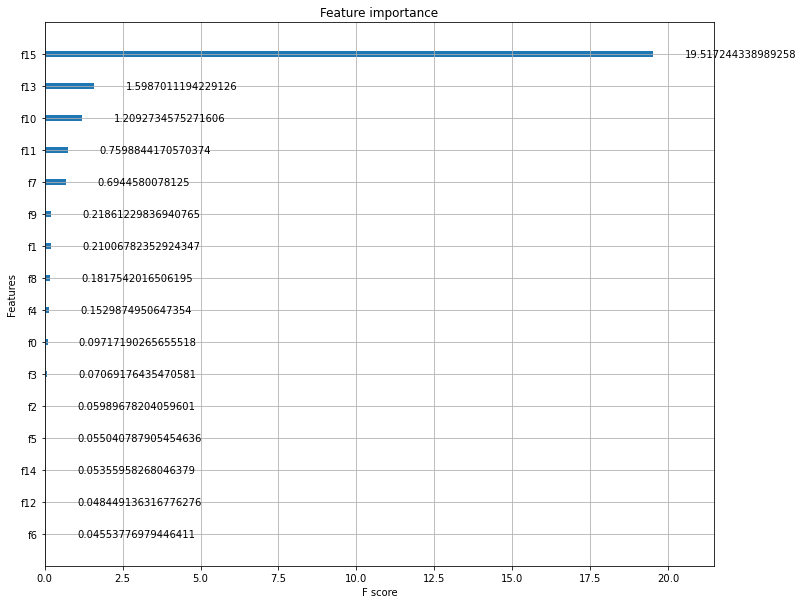

In [101]:
xgb.plot_importance(pipe_xgb.steps[1][1]._Booster, importance_type='total_gain')
plt.show()

In [102]:
results

[('decisiontreeregressor',
  ['Input 14',
   'Input 12',
   'Input 11',
   'Input 08',
   'Input 09',
   'Input 10',
   'Input 05',
   'Input 13',
   'Input 02',
   'Input 07',
   'Input 15',
   'Input 04',
   'Input 01',
   'Input 06',
   'Input 03'],
  {'r2': 0.7753617717548623,
   'neg_root_mean_squared_error': -0.055881016447620516}),
 ('randomforestregressor',
  ['Input 14',
   'Input 11',
   'Input 12',
   'Input 08',
   'Input 10',
   'Input 09',
   'Input 02',
   'Input 05',
   'Input 04',
   'Input 03',
   'Input 07',
   'Input 06',
   'Input 01',
   'Input 15',
   'Input 13'],
  {'r2': 0.8732917190720414,
   'neg_root_mean_squared_error': -0.042086080554349405}),
 ('gradientboostingregressor',
  ['Input 14',
   'Input 12',
   'Input 11',
   'Input 08',
   'Input 10',
   'Input 09',
   'Input 02',
   'Input 05',
   'Input 01',
   'Input 04',
   'Input 15',
   'Input 13',
   'Input 06',
   'Input 07',
   'Input 03'],
  {'r2': 0.9487702156140901,
   'neg_root_mean_squared_error'

In [103]:
with open('result_15I1O.pkl', 'wb') as f:
    pickle.dump(results, f)

In [104]:
with open('result_15I1O.pkl', 'rb') as f:
    r = pickle.load(f)

In [105]:
r

[('decisiontreeregressor',
  ['Input 14',
   'Input 12',
   'Input 11',
   'Input 08',
   'Input 09',
   'Input 10',
   'Input 05',
   'Input 13',
   'Input 02',
   'Input 07',
   'Input 15',
   'Input 04',
   'Input 01',
   'Input 06',
   'Input 03'],
  {'r2': 0.7753617717548623,
   'neg_root_mean_squared_error': -0.055881016447620516}),
 ('randomforestregressor',
  ['Input 14',
   'Input 11',
   'Input 12',
   'Input 08',
   'Input 10',
   'Input 09',
   'Input 02',
   'Input 05',
   'Input 04',
   'Input 03',
   'Input 07',
   'Input 06',
   'Input 01',
   'Input 15',
   'Input 13'],
  {'r2': 0.8732917190720414,
   'neg_root_mean_squared_error': -0.042086080554349405}),
 ('gradientboostingregressor',
  ['Input 14',
   'Input 12',
   'Input 11',
   'Input 08',
   'Input 10',
   'Input 09',
   'Input 02',
   'Input 05',
   'Input 01',
   'Input 04',
   'Input 15',
   'Input 13',
   'Input 06',
   'Input 07',
   'Input 03'],
  {'r2': 0.9487702156140901,
   'neg_root_mean_squared_error'